## imports

In [6]:
import math
import uuid
import time
import numpy as np
from IPython.display import HTML
import itertools
import tensorflow as tf
import os
from utils.data_parser import features_description

from collections import OrderedDict
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import itertools

## Create Dataset

In [7]:

ROOT = os.path.abspath(os.path.dirname(""))
DATADIR = os.path.join(ROOT,"waymo_open_dataset","data","tf_example","training")
RESULTDIR = os.path.join(ROOT,"results")

FILE = "training_tfexample.tfrecord-00000-of-01000"
FILENAME = os.path.join(DATADIR,FILE)
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
data = next(dataset.as_numpy_iterator())
parsed = tf.io.parse_single_example(data, features_description)

## Helper functions for visualization

In [8]:
from cmath import pi


def create_figure_and_axes(size_pixels,axes_x=1,axes_y=1):
  """Initializes a unique figure and axes for plotting."""
  fig, ax = plt.subplots(axes_x,axes_y, num=uuid.uuid4())

  # Sets output image to pixel resolution.
  dpi = 100
  size_inches = size_pixels / dpi
  fig.set_size_inches([size_inches, size_inches])
  fig.set_dpi(dpi)
  fig.set_facecolor('white')
  ax.set_facecolor('white')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(axis='y', colors='black')
  fig.set_tight_layout(True)
  ax.grid(False)
  return fig, ax

def get_viewport(all_states,all_states_mask):
  """
  Gets the region containing the data.

  Args:
    all_states: states of agents as an array of shape [num_agents, num_steps,
      2].
    all_states_mask: binary mask of shape [num_agents, num_steps] for
      `all_states`.

  Returns:
    center_y: float. y coordinate for center of data.
    center_x: float. x coordinate for center of data.
    width: float. Width of data.
  """
  valid_states = all_states[all_states_mask]
  all_y = valid_states[..., 1]
  all_x = valid_states[..., 0]

  center_y = (np.max(all_y) + np.min(all_y)) / 2
  center_x = (np.max(all_x) + np.min(all_x)) / 2

  range_y = np.ptp(all_y)
  range_x = np.ptp(all_x)

  width = max(range_y, range_x)

  return center_y, center_x, width

  
def fig_canvas_image(fig):
  """Returns a [H, W, 3] uint8 np.array image from fig.canvas.tostring_rgb()."""
  # Just enough margin in the figure to display xticks and yticks.
  fig.subplots_adjust(
      left=0.08, bottom=0.08, right=0.98, top=0.98, wspace=0.0, hspace=0.0)
  fig.canvas.draw()
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  return data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

def get_colormap(num_steps):
  """Compute a color map array of shape [num_steps, 4]."""
  colors = cm.get_cmap('jet', num_steps)
  colors = colors(range(num_steps))
  np.random.shuffle(colors)
  return colors

def visualize_one_agent(states,
                        mask,
                        center_y,
                        center_x,
                        color_map,
                        fig,
                        ax,
                        agent_type,
                        width,
                        linewidth=1,
                        traj=True,
                        ):
  """Generate visualization for all steps. num_agents = states[0,:]"""

  masked_x = states[:,0][mask]
  masked_y = states[:,1][mask]
  masked_angle = states[:,2][mask]
  masked_l = states[:,3][mask]
  masked_w = states[:,4][mask]
  # Set axes.  Should be at least 10m on a side and cover 160% of agents.
  size = max(10, width * 1.0)
  ax.axis([
      -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
      size / 2 + center_y
  ])
  ax.set_aspect('equal')

  if traj:
  # Plot one agent trajectory with marker 'o'
    ax.scatter(
      masked_x,
      masked_y,
      marker='o',
      linewidths=linewidth
    )
  else:
    # plot one agent trajectory with rectangualrs 
    for i,(x,y,angle,c) in enumerate(zip(masked_x,masked_y,masked_angle,color_map)):
      rect = plt.Rectangle((x,y),masked_l[i],masked_w[i],angle=angle/pi*180,color=c)
      ax.add_patch(rect)
  image = fig_canvas_image(fig)
  return masked_x[0],masked_y[0]

## Generate visualization images

In [9]:
decoded_example = parsed
# del parsed

# [num_agents, num_past_steps, 5] float32.
past_states = tf.stack(
    [decoded_example['state/past/x'], decoded_example['state/past/y'],decoded_example['state/past/bbox_yaw'],
    decoded_example['state/past/length'],decoded_example['state/past/width']],
    -1).numpy()
past_states_mask = decoded_example['state/past/valid'].numpy() > 0.0

# [num_agents, 1, 5] float32.
current_states = tf.stack(
    [decoded_example['state/current/x'], decoded_example['state/current/y'],decoded_example['state/current/bbox_yaw'],
    decoded_example['state/current/length'],decoded_example['state/current/width']],
    -1).numpy()
current_states_mask = decoded_example['state/current/valid'].numpy() > 0.0

# [num_agents, num_future_steps, 5] float32.
future_states = tf.stack(
    [decoded_example['state/future/x'], decoded_example['state/future/y'],decoded_example['state/future/bbox_yaw'],
    decoded_example['state/future/length'],decoded_example['state/future/width']],
    -1).numpy()
future_states_mask = decoded_example['state/future/valid'].numpy() > 0.0

# [num_points, 3] float32.
roadgraph_xyz = decoded_example['roadgraph_samples/xyz'].numpy()
roadgraph_type = decoded_example['roadgraph_samples/type'].numpy()
roadgraph_lane_id = decoded_example['roadgraph_samples/id'].numpy()
roadgraph_dir_xyz = decoded_example['roadgraph_samples/dir'].numpy()

# concatenate past,current and future states of traffic lights

#[num_steps,num_light_positions]
traffic_lights_id = np.concatenate([decoded_example['traffic_light_state/past/id'].numpy(),decoded_example['traffic_light_state/current/id'].numpy(),decoded_example['traffic_light_state/future/id'].numpy()],axis=0)
traffic_lights_valid_status = np.concatenate([decoded_example['traffic_light_state/past/valid'].numpy(),decoded_example['traffic_light_state/current/valid'].numpy(),decoded_example['traffic_light_state/future/valid'].numpy()],axis=0)
traffic_lights_state = np.concatenate([decoded_example['traffic_light_state/past/state'].numpy(),decoded_example['traffic_light_state/current/state'].numpy(),decoded_example['traffic_light_state/future/state'].numpy()],axis=0)
num_agents, num_past_steps, _ = past_states.shape
num_future_steps = future_states.shape[1]

color_map = get_colormap(91)

# [num_agens, num_past_steps + 1 + num_future_steps, depth] float32.
all_states = np.concatenate([past_states, current_states, future_states], 1)

# [num_agens, num_past_steps + 1 + num_future_steps] float32.
all_states_mask = np.concatenate(
    [past_states_mask, current_states_mask, future_states_mask], 1)





lane freeway has (2, 0) points
lane surface_street has (2, 7237) points
lane bike_lane has (2, 1170) points


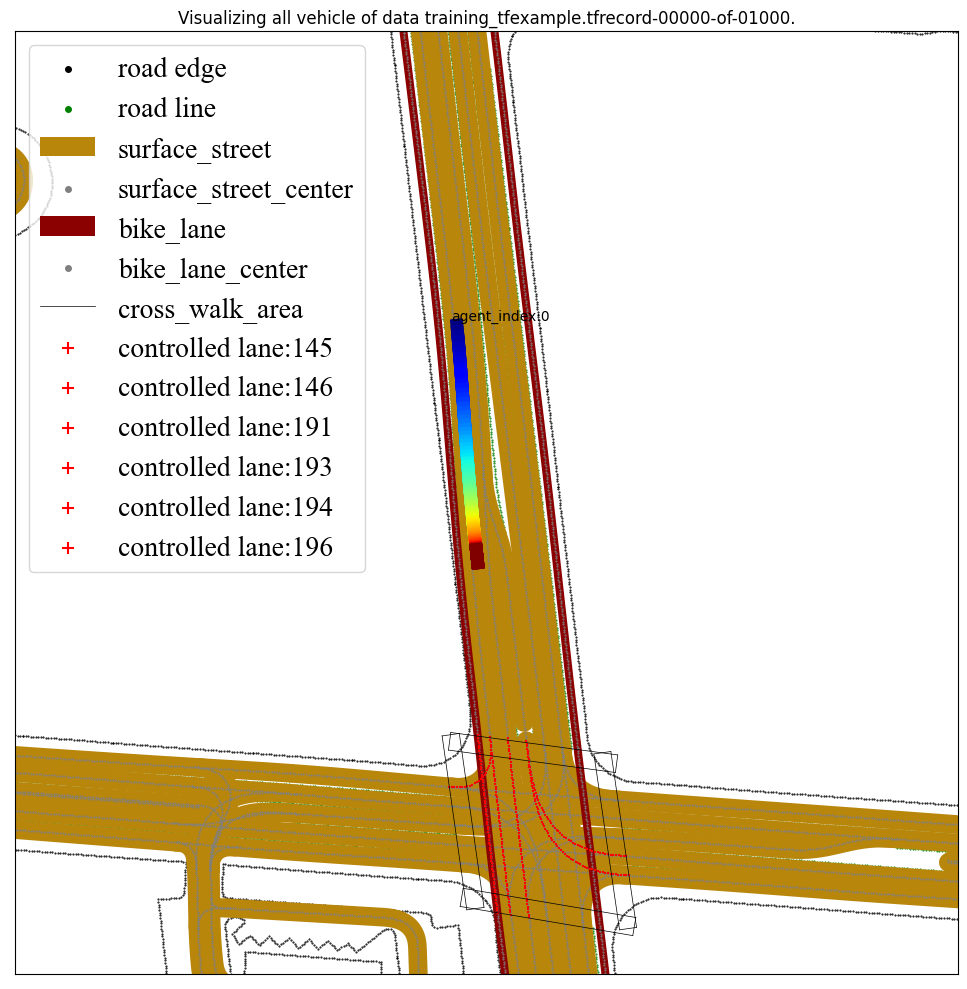

In [20]:
# Create figure and axes.
fig, ax = create_figure_and_axes(size_pixels=1000)
from decimal import InvalidContext
from winsound import PlaySound
from shapely.geometry import LineString,Polygon,Point

"""
    1 - freeway
    2 - surface street
    3 - bike lane
    18 - Crosswalk
    19 - Speed bump
"""
#Plot road graph

# map polylines and polygons are sampled at 0.5 meters. Plot interval 0.1m.
unit_dir = np.array([0,0.5])
# plot road edges
roadedge_mask = np.where((roadgraph_type[:,0]==15) | (roadgraph_type[:,0]==16))[0]
roadedge_pts = roadgraph_xyz[roadedge_mask,:2].T
if (len(roadedge_pts[0,:])>0):
    ax.scatter(roadedge_pts[0,:],roadedge_pts[1,:],c='k',s=1,marker='.',label="road edge")

# plot road lines
roadline_mask = np.where((roadgraph_type[:,0]>=6) & (roadgraph_type[:,0]<=13))[0]
roadline_pts = roadgraph_xyz[roadline_mask,:2].T
if (len(roadline_pts[0,:])>0):
    ax.scatter(roadline_pts[0,:],roadline_pts[1,:],c='g',marker='.',s=1,label="road line")
# Plot lane type
lane_type = {
    'freeway':1,
    'surface_street':2,
    'bike_lane':3
}
lane_width = {
    'freeway':3.5,
    'surface_street':3.5,
    'bike_lane':1.5
}
lane_color = {
    'freeway':'k',
    'surface_street':'darkgoldenrod',
    'bike_lane':'darkred'
}
for key in lane_type:
    lane_mask = np.where(roadgraph_type[:,0]==lane_type[key])[0]
    lane_pts = roadgraph_xyz[lane_mask,:2].T
    lane_dir = roadgraph_dir_xyz[lane_mask,:2].T
    print(f"lane {key} has {lane_pts.shape} points")
    if(len(lane_mask)):
        lane_start = 0
        lane_coordinates = [(lane_pts[0,lane_start],lane_pts[1,lane_start])]
        lane_index = []
        for i,(pt_x,pt_y,dir_x,dir_y) in enumerate(zip(lane_pts[0,:],lane_pts[1,:],lane_dir[0,:],lane_dir[1,:])):
            lane_index.append(i)
            if dir_y==0 and dir_x==0:
                if len(lane_coordinates)>1:
                    lane_polylines = LineString(lane_coordinates)
                    lane_polygon = Polygon(lane_polylines.buffer(lane_width[key]/2))
                    lane_polygon_x,lane_polygon_y = lane_polygon.exterior.xy
                    ax.fill(lane_polygon_x,lane_polygon_y,facecolor=lane_color[key],label=key)
                else:
                    lane_point = Point(lane_coordinates[0]).buffer(lane_width[key]/2)
                    lane_point_x,lane_point_y = lane_point.exterior.xy
                    ax.fill(lane_point_x,lane_point_y,facecolor=lane_color[key],label=key)
                lane_start = i+1
                if lane_start == len(lane_pts[0,:]):
                    break
                else:
                    lane_coordinates = [(lane_pts[0,lane_start],lane_pts[1,lane_start])]
                    lane_index = []
            for j,(pt_x_2,pt_y_2) in enumerate(zip(lane_pts[0,:],lane_pts[1,:])):
                if dir_x == 0 and dir_y != 0:
                    if pt_x_2 == pt_x:
                        lane_coordinates.append((pt_x_2,pt_y_2))
                        lane_index.append(j)
                        break
                elif dir_y == 0 and dir_x != 0:
                    if pt_y_2 == pt_y:
                        lane_coordinates.append((pt_x_2,pt_y_2))
                        lane_index.append(j)
                        break
                elif dir_x !=0 and dir_y != 0:
                    if np.abs((pt_x_2-pt_x)/dir_x-(pt_y_2-pt_y)/dir_y) < 1e-10:
                        lane_coordinates.append((pt_x_2,pt_y_2))
                        lane_index.append(j)
                        break

        ax.scatter(lane_pts[0,:],lane_pts[1,:],c='gray',marker='.',s=1,label=f"{key}_center")

# Plot cross walk polylines
road_lanes_polylines={
    'cross_walk_area':18
}
road_lanes_polylines_mask = np.where((roadgraph_type[:,0]==18))[0]
road_lanes_polylines_pts = roadgraph_xyz[road_lanes_polylines_mask,:2].T
road_lanes_polylines_dir = roadgraph_dir_xyz[road_lanes_polylines_mask,:2].T
for key in road_lanes_polylines:
    if len(road_lanes_polylines_mask):
        polygon_start = 0
        for i,(pt_x,pt_y,dir_x,dir_y) in enumerate(zip(road_lanes_polylines_pts[0,:],road_lanes_polylines_pts[1,:],road_lanes_polylines_dir[0,:],road_lanes_polylines_dir[1,:])):
            if dir_y==0 and dir_x==0:
                ax.plot([pt_x,road_lanes_polylines_pts[0,polygon_start]],[pt_y,road_lanes_polylines_pts[1,polygon_start]],c='k',linewidth=0.5,label=key)
                polygon_start = i+1
                continue
            for j,(pt_x_2,pt_y_2) in enumerate(zip(road_lanes_polylines_pts[0,:],road_lanes_polylines_pts[1,:])):
                if i==j:
                    continue
                if dir_x==0 and dir_y!=0:
                    if pt_x_2==pt_x:
                        ax.plot([pt_x,pt_x_2],[pt_y,pt_y_2],c='k',linewidth=0.5,label=key)
                        break
                elif dir_y==0 and dir_x!=0:
                    if pt_y_2==pt_y:
                        ax.plot([pt_x,pt_x_2],[pt_y,pt_y_2],c='k',linewidth=0.5,label=key)
                        break
                elif dir_x!=0 and dir_y!=0:
                    if np.abs((pt_x_2-pt_x)/dir_x-(pt_y_2-pt_y)/dir_y) < 1e-1:
                        ax.plot([pt_x,pt_x_2],[pt_y,pt_y_2],c='k',linewidth=0.5,label=key)
                        break

# plot controlled lanes
controlled_lanes_id = np.unique(traffic_lights_id[traffic_lights_valid_status==1])
if len(controlled_lanes_id):
    for controlled_lane_id in controlled_lanes_id:
        controlled_lanes_pts = np.where(roadgraph_lane_id==controlled_lane_id)[0]
        if(len(controlled_lanes_pts)):
            ax.scatter(roadgraph_xyz[controlled_lanes_pts,0],roadgraph_xyz[controlled_lanes_pts,1],s=1,c='r',marker='+',label=f"controlled lane:{controlled_lane_id}")

from pickle import FALSE
from rich.progress import track

SHOW_VEHICLE = False
agent_list = ["","vehicle","pedestrian","cyclist",""]
if SHOW_VEHICLE:
    vehicle_id = 1105.0
    vru_id = 4288.0
    vehicle_ind = np.where(decoded_example['state/id']==vehicle_id)[0][0]
    vru_ind = np.where(decoded_example['state/id']==vru_id)[0][0]
    states = np.concatenate(([all_states[vehicle_ind,:,:]],[all_states[vru_ind,:,:]]))
    states_mask = np.concatenate(([all_states_mask[vehicle_ind,:]],[all_states_mask[vru_ind,:]]))
    agent_type = [decoded_example['state/type'].numpy()[ind] for ind in [vehicle_ind,vru_ind]]
else:
    agent_type = np.ones(128,np.int8)*1
    vru_id = np.where(decoded_example['state/type']==agent_type[0])[0]
    states = all_states[vru_id,:,:]
    states_mask = all_states_mask[vru_id,:]
# Generate image from all time steps
vs = np.linspace(0,100,91)
normal = plt.Normalize(0,91)
color_map = [plt.cm.Greys(normal(vs)),plt.cm.jet(normal(vs)),plt.cm.jet(normal(vs)),plt.cm.jet(normal(vs)),plt.cm.Purples(normal(vs))]

# visualize all agents in the scene
center_y, center_x, width = get_viewport(all_states, all_states_mask)
index = 1
for i, (s,m) in enumerate (zip(states,states_mask)):
    if i==index:
        x,y = visualize_one_agent(s,m,center_y,center_x,color_map[int(agent_type[i])],fig,ax,int(agent_type[i]),width,traj=False)
        ax.text(x,y,f"agent_index:{index}")
        break

title = f'Visualizing all {agent_list[agent_type[0]]} of data {FILE}.'
ax.set_title(title)

handels,labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels,handels))
font1 = {'family' : 'Times New Roman','weight' : 'normal','size':20}
ax.legend(by_label.values(),by_label.keys(),loc="upper left",markerscale=8.0,prop=font1)
plt.xticks([])
plt.yticks([])
FIGDIR=os.path.join(os.path.abspath(""),"figures/relation_actor_lane")
plt.savefig(f"{FIGDIR}\{FILE}{agent_list[agent_type[0]]}_index{index}.jpg")
plt.tight_layout()

plt.show()

lane freeway has (2, 0) points
lane surface_street has (2, 7237) points
lane bike_lane has (2, 1170) points


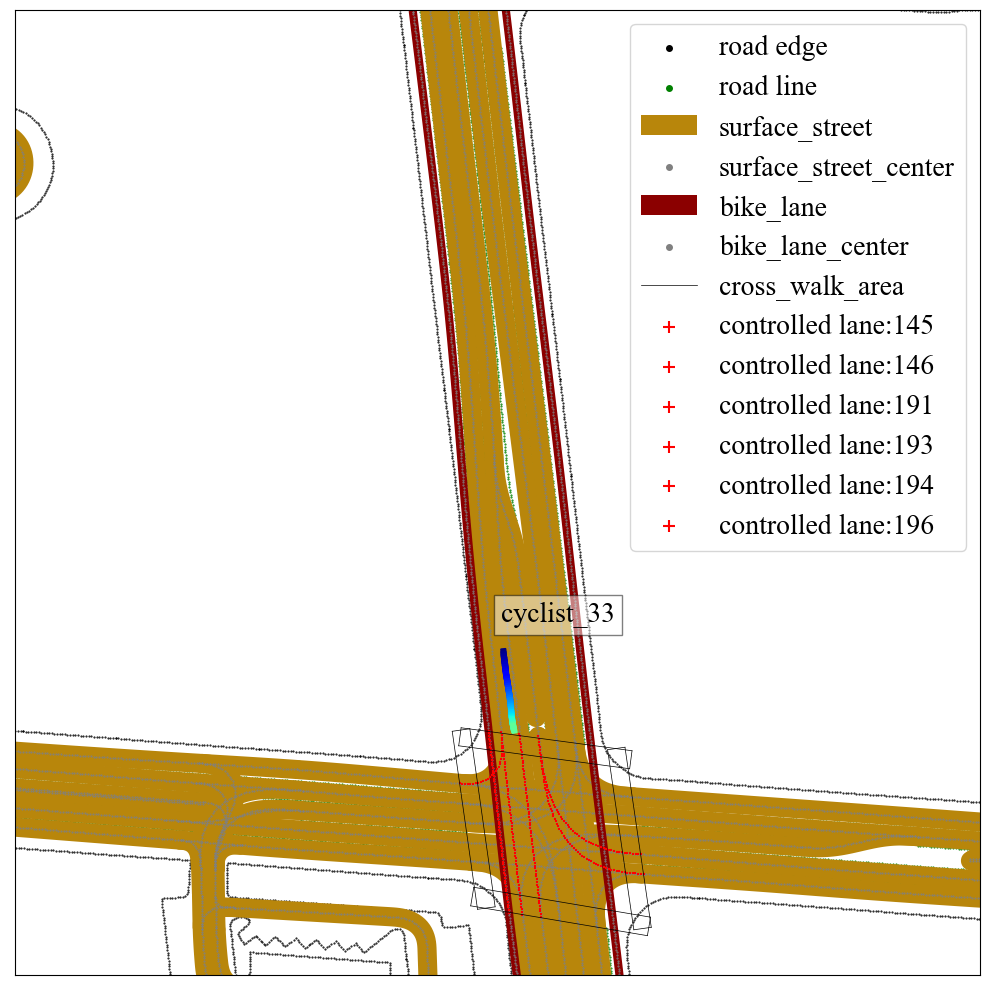

In [32]:
# Create figure and axes.
fig, ax = create_figure_and_axes(size_pixels=1000)
from decimal import InvalidContext
from winsound import PlaySound
from shapely.geometry import LineString,Polygon,Point

"""
    1 - freeway
    2 - surface street
    3 - bike lane
    18 - Crosswalk
    19 - Speed bump
"""
#Plot road graph

# map polylines and polygons are sampled at 0.5 meters. Plot interval 0.1m.
unit_dir = np.array([0,0.5])
# plot road edges
roadedge_mask = np.where((roadgraph_type[:,0]==15) | (roadgraph_type[:,0]==16))[0]
roadedge_pts = roadgraph_xyz[roadedge_mask,:2].T
if (len(roadedge_pts[0,:])>0):
    ax.scatter(roadedge_pts[0,:],roadedge_pts[1,:],c='k',s=1,marker='.',label="road edge")

# plot road lines
roadline_mask = np.where((roadgraph_type[:,0]>=6) & (roadgraph_type[:,0]<=13))[0]
roadline_pts = roadgraph_xyz[roadline_mask,:2].T
if (len(roadline_pts[0,:])>0):
    ax.scatter(roadline_pts[0,:],roadline_pts[1,:],c='g',marker='.',s=1,label="road line")
# Plot lane type
lane_type = {
    'freeway':1,
    'surface_street':2,
    'bike_lane':3
}
lane_width = {
    'freeway':3.5,
    'surface_street':3.5,
    'bike_lane':1.5
}
lane_color = {
    'freeway':'k',
    'surface_street':'darkgoldenrod',
    'bike_lane':'darkred'
}
for key in lane_type:
    lane_mask = np.where(roadgraph_type[:,0]==lane_type[key])[0]
    lane_pts = roadgraph_xyz[lane_mask,:2].T
    lane_dir = roadgraph_dir_xyz[lane_mask,:2].T
    print(f"lane {key} has {lane_pts.shape} points")
    if(len(lane_mask)):
        lane_start = 0
        lane_coordinates = [(lane_pts[0,lane_start],lane_pts[1,lane_start])]
        lane_index = []
        for i,(pt_x,pt_y,dir_x,dir_y) in enumerate(zip(lane_pts[0,:],lane_pts[1,:],lane_dir[0,:],lane_dir[1,:])):
            lane_index.append(i)
            if dir_y==0 and dir_x==0:
                if len(lane_coordinates)>1:
                    lane_polylines = LineString(lane_coordinates)
                    lane_polygon = Polygon(lane_polylines.buffer(lane_width[key]/2))
                    lane_polygon_x,lane_polygon_y = lane_polygon.exterior.xy
                    ax.fill(lane_polygon_x,lane_polygon_y,facecolor=lane_color[key],label=key)
                else:
                    lane_point = Point(lane_coordinates[0]).buffer(lane_width[key]/2)
                    lane_point_x,lane_point_y = lane_point.exterior.xy
                    ax.fill(lane_point_x,lane_point_y,facecolor=lane_color[key],label=key)
                lane_start = i+1
                if lane_start == len(lane_pts[0,:]):
                    break
                else:
                    lane_coordinates = [(lane_pts[0,lane_start],lane_pts[1,lane_start])]
                    lane_index = []
            for j,(pt_x_2,pt_y_2) in enumerate(zip(lane_pts[0,:],lane_pts[1,:])):
                if dir_x == 0 and dir_y != 0:
                    if pt_x_2 == pt_x:
                        lane_coordinates.append((pt_x_2,pt_y_2))
                        lane_index.append(j)
                        break
                elif dir_y == 0 and dir_x != 0:
                    if pt_y_2 == pt_y:
                        lane_coordinates.append((pt_x_2,pt_y_2))
                        lane_index.append(j)
                        break
                elif dir_x !=0 and dir_y != 0:
                    if np.abs((pt_x_2-pt_x)/dir_x-(pt_y_2-pt_y)/dir_y) < 1e-10:
                        lane_coordinates.append((pt_x_2,pt_y_2))
                        lane_index.append(j)
                        break

        ax.scatter(lane_pts[0,:],lane_pts[1,:],c='gray',marker='.',s=1,label=f"{key}_center")

# Plot cross walk polylines
road_lanes_polylines={
    'cross_walk_area':18
}
road_lanes_polylines_mask = np.where((roadgraph_type[:,0]==18))[0]
road_lanes_polylines_pts = roadgraph_xyz[road_lanes_polylines_mask,:2].T
road_lanes_polylines_dir = roadgraph_dir_xyz[road_lanes_polylines_mask,:2].T
for key in road_lanes_polylines:
    if len(road_lanes_polylines_mask):
        polygon_start = 0
        for i,(pt_x,pt_y,dir_x,dir_y) in enumerate(zip(road_lanes_polylines_pts[0,:],road_lanes_polylines_pts[1,:],road_lanes_polylines_dir[0,:],road_lanes_polylines_dir[1,:])):
            if dir_y==0 and dir_x==0:
                ax.plot([pt_x,road_lanes_polylines_pts[0,polygon_start]],[pt_y,road_lanes_polylines_pts[1,polygon_start]],c='k',linewidth=0.5,label=key)
                polygon_start = i+1
                continue
            for j,(pt_x_2,pt_y_2) in enumerate(zip(road_lanes_polylines_pts[0,:],road_lanes_polylines_pts[1,:])):
                if i==j:
                    continue
                if dir_x==0 and dir_y!=0:
                    if pt_x_2==pt_x:
                        ax.plot([pt_x,pt_x_2],[pt_y,pt_y_2],c='k',linewidth=0.5,label=key)
                        break
                elif dir_y==0 and dir_x!=0:
                    if pt_y_2==pt_y:
                        ax.plot([pt_x,pt_x_2],[pt_y,pt_y_2],c='k',linewidth=0.5,label=key)
                        break
                elif dir_x!=0 and dir_y!=0:
                    if np.abs((pt_x_2-pt_x)/dir_x-(pt_y_2-pt_y)/dir_y) < 1e-1:
                        ax.plot([pt_x,pt_x_2],[pt_y,pt_y_2],c='k',linewidth=0.5,label=key)
                        break

# plot controlled lanes
controlled_lanes_id = np.unique(traffic_lights_id[traffic_lights_valid_status==1])
if len(controlled_lanes_id):
    for controlled_lane_id in controlled_lanes_id:
        controlled_lanes_pts = np.where(roadgraph_lane_id==controlled_lane_id)[0]
        if(len(controlled_lanes_pts)):
            ax.scatter(roadgraph_xyz[controlled_lanes_pts,0],roadgraph_xyz[controlled_lanes_pts,1],s=1,c='r',marker='+',label=f"controlled lane:{controlled_lane_id}")

from pickle import FALSE
from rich.progress import track

SHOW_VEHICLE = False
agent_list = ["","vehicle","pedestrian","cyclist",""]

# Generate image from all time steps
vs = np.linspace(0,100,91)
normal = plt.Normalize(0,91)
color_map = [plt.cm.Greys(normal(vs)),plt.cm.jet(normal(vs)),plt.cm.jet(normal(vs)),plt.cm.jet(normal(vs)),plt.cm.Purples(normal(vs))]

# visualize all agents in the scene
center_y, center_x, width = get_viewport(all_states, all_states_mask)
agent_type=3
index = 33
font1 = {'family' : 'Times New Roman','weight' : 'normal','size':20}
for i, (s,m) in enumerate (zip(all_states,all_states_mask)):
    if i==index:
        x,y = visualize_one_agent(s,m,center_y,center_x,color_map[agent_type],fig,ax,agent_type,width,traj=False)
        ax.text(x,y+5,f"{agent_list[agent_type]}_{index}",fontdict=font1,bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})
        break

title = f'Visualizing all {agent_list[agent_type]} of data {FILE}.'
# ax.set_title(title)

handels,labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels,handels))

ax.legend(by_label.values(),by_label.keys(),loc="upper right",markerscale=8.0,prop=font1)
plt.xticks([])
plt.yticks([])
FIGDIR=os.path.join(os.path.abspath(""),"figures/relation_actor_lane")
plt.savefig(f"{FIGDIR}\{FILE}{agent_list[agent_type]}_index{index}.jpg")
plt.tight_layout()

plt.show()

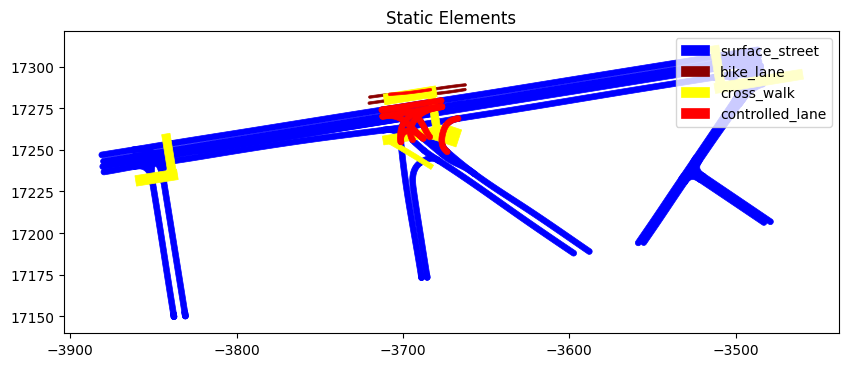

In [43]:
from utils.static_elements import StaticElementsWaymo
original_data_roadgragh = {
    'roadgraph_xyz':roadgraph_xyz,
    'roadgraph_type':roadgraph_type,
    'roadgraph_dir_xyz':roadgraph_dir_xyz,
    'roadgraph_lane_id':roadgraph_lane_id
}
original_data_light = {
    'traffic_lights_id':traffic_lights_id,
    'traffic_lights_valid_status':traffic_lights_valid_status,
    'traffic_lights_state':traffic_lights_state
}
static_element = StaticElementsWaymo(original_data_roadgragh,original_data_light)
static_element.create_polygon_set()
bike_lanes = static_element.get_lane('bike_lane')
cross_walk = static_element.get_other_object('cross_walk')
controlled_lanes,_ = static_element.get_controlled_lane()
surface_street = static_element.get_lane('surface_street')
fig,ax = plt.subplots(figsize=(10,10))

for surface in surface_street:
    surface_x,surface_y = surface.exterior.xy
    ax.fill(surface_x,surface_y,c='blue',linewidth=0.5,label='surface_street')

for bike_lane in bike_lanes:
    bike_lane_x,bike_lane_y = bike_lane.exterior.xy
    ax.fill(bike_lane_x,bike_lane_y,c='darkred',linewidth=0.5,label='bike_lane')

for cross in cross_walk:
    cross_x,cross_y = cross.exterior.xy
    ax.fill(cross_x,cross_y,c='yellow',linewidth=0.5,label='cross_walk')

for controlled_lane in controlled_lanes:
    controlled_lane_x,controlled_lane_y = controlled_lane.exterior.xy
    ax.fill(controlled_lane_x,controlled_lane_y,c='red',linewidth=0.5,label='controlled_lane')

ax.set_title('Static Elements')
ax.set_aspect('equal','box')
handels,labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels,handels))

ax.legend(by_label.values(),by_label.keys(),loc="upper right",markerscale=5.0)


plt.show()

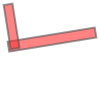

In [46]:
from shapely.geometry import MultiPolygon
two_crosswalk = MultiPolygon([cross_walk[0],cross_walk[1]])
two_crosswalk

#### Thinking of a faster creator for lanes polylines. maybe later...

In [ ]:
# Create figure and axes.
fig, ax = create_figure_and_axes(size_pixels=1000)
from shapely.geometry import LineString,Polygon

"""
    1 - freeway
    2 - surface street
    3 - bike lane
    18 - Crosswalk
    19 - Speed bump
"""

lane_mask = np.where(roadgraph_type[:,0]==2)[0]
lane_pts = roadgraph_xyz[lane_mask,:2].T
lane_dir = roadgraph_dir_xyz[lane_mask,:2].T
print(f"lane surface has {lane_pts.shape} points")
if(len(lane_mask)):
    # find where dir_x=dir_y=0
    lane_end_pt_index = np.where(lane_dir[0,:]*lane_dir[1,:]==0)[0]
    # find the single point that is not in the end point
    lane_end_pt_single_pt_index = np.where(np.diff(lane_end_pt_index)==1)[0]
    # check for the first point
    lane_end_pt_single_pt_index = np.insert(lane_end_pt_single_pt_index,0,0) if lane_dir[0,0]*lane_dir[0,1]==0 else lane_end_pt_single_pt_index
    lane_end_pt_index = np.delete(lane_end_pt_index,lane_end_pt_single_pt_index)
    # splite lanes np.split at lane_end_pt_index. the index is included by +1
    lanes_polylines_pts = np.split(lane_pts,lane_end_pt_index+1,axis=1)
    lanes_points_pts = lane_pts[:,lane_end_pt_single_pt_index].reshape(-1,2)
    for lanes_polyline_pts in lanes_polylines_pts:
        try:
            lane_polylines = LineString(lanes_polyline_pts.reshape(-1,2))
            lane_polygon = Polygon(lane_polylines.buffer(3.5/2))
            lane_polygon_x,lane_polygon_y = lane_polygon.exterior.xy
            ax.fill(lane_polygon_x,lane_polygon_y,facecolor='b',label='surface street')
        except:
            print(lanes_polyline_pts.reshape(-1,2))
    for lanes_point_pts in lanes_points_pts:
        lane_point = Point(lanes_point_pts).buffer(3.5/2)
        lane_point_x,lane_point_y = lane_point.exterior.xy
        ax.fill(lane_point_x,lane_point_y,facecolor='b',label='surface street')



# if(len(lane_mask)):
#     lane_start = 0
#     lane_coordinates = [(lane_pts[0,lane_start],lane_pts[1,lane_start])]
#     for i,(pt_x,pt_y,dir_x,dir_y) in enumerate(zip(lane_pts[0,:],lane_pts[1,:],lane_dir[0,:],lane_dir[1,:])):
#         if dir_y*dir_x==0:
#             if len(lane_coordinates)>1:
#                 lane_polylines = LineString(lane_coordinates)
#                 lane_polygon = Polygon(lane_polylines.buffer(lane_width[key]/2))
#                 lane_polygon_x,lane_polygon_y = lane_polygon.exterior.xy
#                 ax.fill(lane_polygon_x,lane_polygon_y,facecolor=lane_color[key],label=key)
#             lane_start = i+1
#             if lane_start == len(lane_pts[0,:]):
#                 break
#             else:
#                 lane_coordinates = [(lane_pts[0,lane_start],lane_pts[1,lane_start])]
#         for j,(pt_x_2,pt_y_2) in enumerate(zip(lane_pts[0,lane_start:],lane_pts[1,lane_start:])):
#             if dir_x == 0 and dir_y != 0:
#                 if pt_x_2 == pt_x:
#                     lane_coordinates.append((pt_x_2,pt_y_2))
#                     break
#             elif dir_y == 0 and dir_x != 0:
#                 if pt_y_2 == pt_y:
#                     lane_coordinates.append((pt_x_2,pt_y_2))
#                     break
#             elif dir_x !=0 and dir_y != 0:
#                 if np.abs((pt_x_2-pt_x)/dir_x-(pt_y_2-pt_y)/dir_y) < 1e-1:
#                     lane_coordinates.append((pt_x_2,pt_y_2))
#                     break

        # ax.scatter(lane_pts[0,:],lane_pts[1,:],marker='x',s=2,label=key)